In [1]:
import math
import numpy as np
import re

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C

image_files = files_in_folder('./image_data_outer')
image_files_2 = files_in_folder('./image_data_outer_2')
# image_files = files_in_folder('./image_data_inner')

In [3]:
def get_a_v(filename):
    split = filename.split('_')
    a = split[3][1:-4]
    v = split[2][1:]
    return (float(v), float(a))

In [4]:
# load images and parse out accel and velocity
data = np.concatenate([np.array([[np.array(Image.open(f'image_data_outer/{f}')), *get_a_v(f)] for f in image_files]),
        np.array([[np.array(Image.open(f'image_data_outer_2/{f}')), *get_a_v(f)] for f in image_files_2])])
# data = np.array([[np.array(Image.open(f'image_data_inner/{f}')), *get_a_v(f)] for f in image_files])

In [5]:
#shuffle dat shiz
np.random.shuffle(data)

In [6]:
X_data = np.stack(data[:, 0])/255
Y_data = np.stack(data[:, 1:])

In [31]:
# for when you realize that the data takes up too much memory
data = None
X_data = None
Y_data = None
import gc
gc.collect()

19

In [32]:
len(X_data)

TypeError: object of type 'NoneType' has no len()

In [24]:
# keras go brr time
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from tensorflow.keras import metrics

In [9]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [10]:
# Model def
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(360, 640, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(2, activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 638, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 319, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 317, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 158, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 156, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 78, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 76, 128)       1

In [12]:

LEARNING_RATE = 1e-4
conv_model.compile(loss='MSE',
                   optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                   metrics=[metrics.RootMeanSquaredError()])

In [13]:
reset_weights(conv_model)

In [ ]:
VALIDATION_SPLIT = 0.2
history_conv = conv_model.fit(X_data, Y_data, 
                              validation_split=VALIDATION_SPLIT,
                              epochs=5,
                              batch_size=16)

In [80]:
# all_image_files = np.array(['image_data_outer/' + f for f in image_files] + ['image_data_outer_2/' + f for f in image_files_2])
all_image_files = np.array(['image_data_outer_2/' + f for f in image_files_2])
np.random.shuffle(all_image_files)
def generate_data(image_files, batch_size):
    while True:
        chunks = int(len(image_files)/batch_size * 2)
        for image_file_chunk in np.array_split(image_files, chunks):
            imgs = []
            movs = []
            for image_file in image_file_chunk:
                img = np.array(Image.open(image_file)) / 255
                mov = np.array([*get_a_v(image_file.split('/')[1])])
                imgs.append(img)
                movs.append(mov)
                # flip image and turning
                mov_flip = mov.copy()
                mov_flip[1] *= -1
                imgs.append(np.flip(img, axis=1))
                movs.append(mov_flip)
            
            yield (np.stack(imgs, 0), np.stack(movs, 0))

In [73]:
# training but on larger datasets
import tensorflow as tf
conv_model = tf.keras.models.load_model('drive_model')

In [81]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16

files_split = int(len(all_image_files) * (1 - VALIDATION_SPLIT))
train_image_files = all_image_files[:files_split]
validation_image_files = all_image_files[files_split:]


chunks_train = int(len(train_image_files)/BATCH_SIZE * 2)
chunks_validate = int(len(validation_image_files)/BATCH_SIZE * 2)

history_conv = conv_model.fit_generator(generate_data(train_image_files, BATCH_SIZE),
                              steps_per_epoch=chunks_train,
                              validation_data=generate_data(validation_image_files, BATCH_SIZE),
                              validation_steps=chunks_validate,
                              epochs=5)

Epoch 1/5
210/210 [==============================] - 264s 1s/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1294
Epoch 2/5
210/210 [==============================] - 264s 1s/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1349
Epoch 3/5
210/210 [==============================] - 266s 1s/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1358
Epoch 4/5
210/210 [==============================] - 266s 1s/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1360
Epoch 5/5
210/210 [==============================] - 266s 1s/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1456


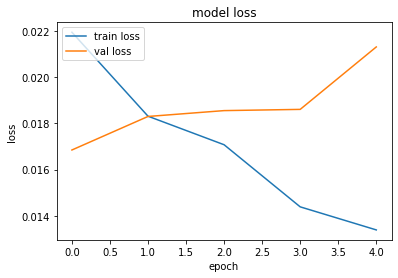

In [83]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

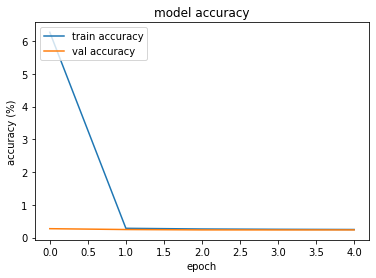

In [63]:
plt.plot(history_conv.history['root_mean_squared_error'])
plt.plot(history_conv.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

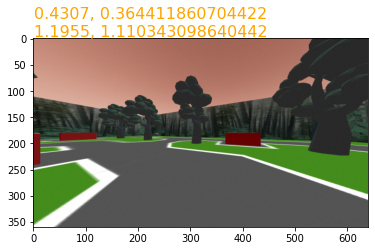

In [28]:
# Display images in the training data set. 
def displayImage(index):
  img = X_data[index]
  
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]
  
  plt.imshow(img)  
  caption = (f'{Y_data[index][0]}, {y_predict[0]}\n' +
             f'{Y_data[index][1]}, {y_predict[1]}')
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')


# interact(displayImage, 
#         index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
#                                    step=1, value=10))
displayImage(110)

In [84]:
# conv_model.save('drive_model')
conv_model.save('drive_model_improved_2')

In [15]:
# below here is just messing around

In [2]:
test_img = np.array(Image.open('test_img_2.png'))

In [14]:
plt.imshow(test_img)

NameError: name 'test_img_2' is not defined

In [124]:
def check_left(img,x1,x2):
    img_diff = np.amax(img[x1:x2,:600,:], axis=2) - np.amin(img[x1:x2,:600,:], axis=2)
    img_mean = np.mean(img[x1:x2,:600,:], axis=2)
    grey_on_line = (img_diff < 10) * (img_mean < 100)
    plt.imshow(grey_on_line == 0)
    return np.sum(grey_on_line == 0) < 10

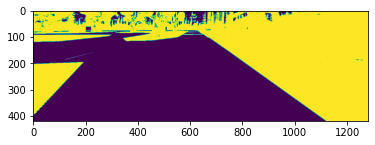

In [4]:
plt.imshow(((np.amax(test_img[300:,:,:], axis=2) - np.amin(test_img[300:,:,:], axis=2)) < 10)
           * np.mean(test_img[300:,:,:], axis=2) < 50)

In [104]:
get_grey(test_img)

True

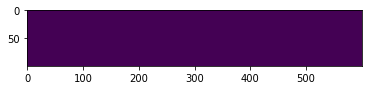

In [107]:
img_diff = np.amax(test_img[400:500,:600,:], axis=2) - np.amin(test_img[400:500,:600,:], axis=2)
img_mean = np.mean(test_img[400:500,:600,:], axis=2)
grey_on_line = (img_diff < 10) * (img_mean < 50)
plt.imshow(grey_on_line)

True

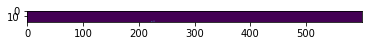

In [130]:
check_left(test_img, 440, 460)

In [9]:
test_img = np.array(Image.open('test_img_2.png'))

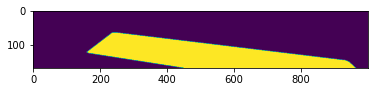

In [22]:
plt.imshow(test_img[550:,100:1100,0] - np.mean(test_img[550:,100:1100,:], axis=2) > 150)

In [25]:
np.sum(test_img[550:,100:1100,0] - np.mean(test_img[550:,100:1100,:], axis=2) > 150)

45160

In [26]:
test_img.shape

(720, 1280, 3)

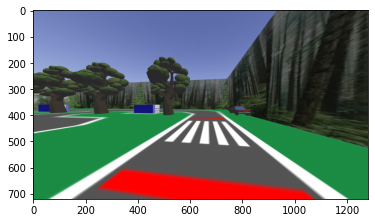

In [16]:
plt.imshow(test_img)

In [27]:
test_img = np.array(Image.open('image_dude.png'))

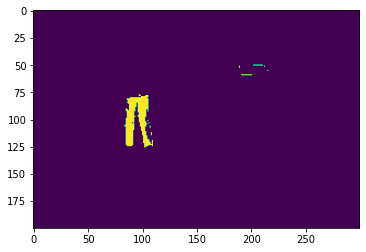

In [64]:
rel_blue = test_img[:,:,2] - np.mean(test_img, axis=2)
rel_blue = rel_blue[300:500, 500:800]

plt.imshow((rel_blue > 5) & (rel_blue < 25))

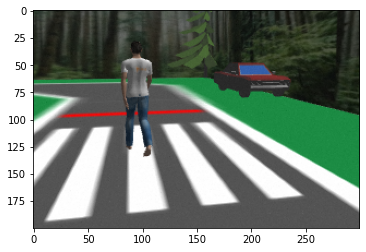

In [62]:
plt.imshow(test_img[300:500, 500:800])

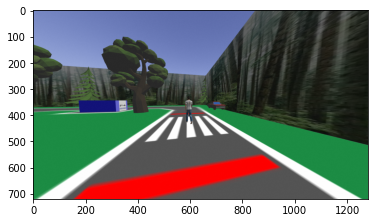

In [63]:
plt.imshow(test_img)

In [65]:
np.sum((rel_blue > 5) & (rel_blue < 25))

697

In [86]:
import cv2
img_1 = np.array(Image.open('image_data_inner/driving_16_v0.4348_a0.9275.png'))
img_2 = np.array(Image.open('image_data_inner/driving_17_v0.4481_a0.9827.png'))

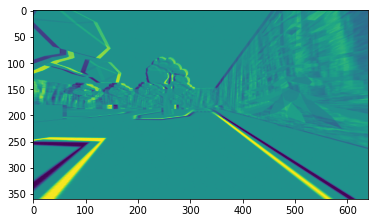

In [87]:
img_1_g = np.mean(img_1, axis=2)
img_2_g = np.mean(img_2, axis=2)
plt.imshow(img_1_g[:,:] - img_2_g[:,:])

In [102]:
flow = cv2.calcOpticalFlowFarneback(img_1_g,img_2_g, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

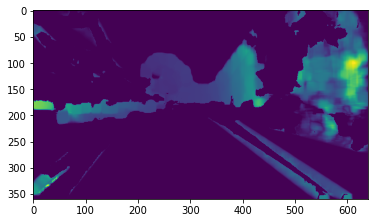

In [118]:
plt.imshow(mag * (((ang > np.pi * 1) & (ang > np.pi * 0))))

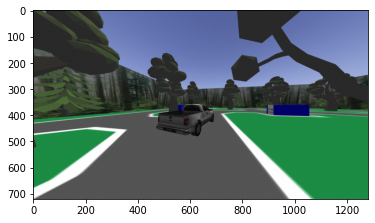

In [149]:
img_1 = np.array(Image.open('image_truck.png'))
plt.imshow(img_1)

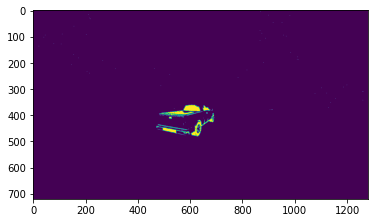

In [165]:
img_diff = np.amax(img_1, axis=2) - np.amin(img_1, axis=2)
img_mean = np.mean(img_1, axis=2)
img_1_g = np.mean(img_1, axis=2)

grey = (img_diff == 0) * (img_mean < 30)
plt.imshow(grey)

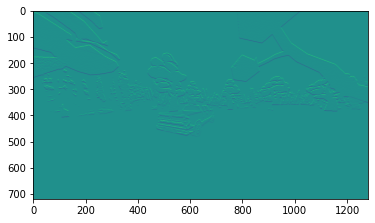

In [141]:
plt.imshow(grey[1:,:] - grey[:-1,:])

In [82]:
print('''
░░░░░░░░▀▀▀██████▄▄▄░░░░░░░░░░░░
░░░░░░▄▄▄▄▄░░█████████▄░░░░░░░░░
░░░░░▀▀▀▀█████▌░▀▐▄░▀▐█░░░░░░░░░
░░░▀▀█████▄▄░▀██████▄██░░░░░░░░░
░░░▀▄▄▄▄▄░░▀▀█▄▀█════█▀░░░░░░░░░
░░░░░░░░▀▀▀▄░░▀▀███░▀░░░░░░▄▄░░░
░░░░░▄███▀▀██▄████████▄░▄▀▀▀██▌░
░░░██▀▄▄▄██▀▄███▀░▀▀████░░░░░▀█▄
▄▀▀▀▄██▄▀▀▌████▒▒▒▒▒▒███░░░░▌▄▄▀
▌░░░░▐▀████▐███▒▒▒▒▒▐██▌░░░░░░░░
▀▄░░▄▀░░░▀▀████▒▒▒▒▄██▀░░░░░░░░░
░░▀▀░░░░░░▀▀█████████▀░░░░░░░░░░''')

░░░░░░░░▀▀▀██████▄▄▄░░░░░░░░░░░░
░░░░░░▄▄▄▄▄░░█████████▄░░░░░░░░░
░░░░░▀▀▀▀█████▌░▀▐▄░▀▐█░░░░░░░░░
░░░▀▀█████▄▄░▀██████▄██░░░░░░░░░
░░░▀▄▄▄▄▄░░▀▀█▄▀█════█▀░░░░░░░░░
░░░░░░░░▀▀▀▄░░▀▀███░▀░░░░░░▄▄░░░
░░░░░▄███▀▀██▄████████▄░▄▀▀▀██▌░
░░░██▀▄▄▄██▀▄███▀░▀▀████░░░░░▀█▄
▄▀▀▀▄██▄▀▀▌████▒▒▒▒▒▒███░░░░▌▄▄▀
▌░░░░▐▀████▐███▒▒▒▒▒▐██▌░░░░░░░░
▀▄░░▄▀░░░▀▀████▒▒▒▒▄██▀░░░░░░░░░
░░▀▀░░░░░░▀▀█████████▀░░░░░░░░░░
